# CLIP Vector Search & Clustering Feasibility Study

**Optimization: Cluster-First, Then Label Approach**

Instead of labeling each image individually with VLM (expensive), we:
1. **Cluster first** using CLIP embeddings (fast, CPU-only)
2. **Label clusters** by providing VLM with multiple representative images from each cluster

**Benefits:**
- Reduces VLM API calls: 1 per cluster instead of 1 per image
- More consistent cluster names (VLM sees multiple examples)
- Cost-effective (fewer API calls)
- Aligns with spec: clusters get names, not individual images


In [11]:
%pip install --quiet sentence-transformers pillow matplotlib scikit-learn numpy google-generativeai python-dotenv requests



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import io
import json
import os
import re
import time
from collections import Counter, defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn.functional as F
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

DEVICE = "cpu"


In [ ]:
def label_cluster_with_vlm(
    cluster_images: List[Image.Image],
    cluster_id: int,
    gemini_model=None,
    max_images: int = 5
) -> Dict[str, object]:
    """
    Efficient cluster labeling: Provide VLM with multiple images from cluster.
    
    This is MUCH more efficient than labeling each image individually:
    - 1 API call per cluster instead of 1 per image
    - VLM sees multiple examples, produces better cluster names
    - Reduces cost and latency significantly
    
    Args:
        cluster_images: List of images in the cluster
        cluster_id: Cluster identifier
        gemini_model: Initialized Gemini model (or None for fallback)
        max_images: Max images to send (to stay within token limits)
    
    Returns:
        Dictionary with cluster_name, description, tags, etc.
    """
    if gemini_model is None:
        return {
            "cluster_name": f"Cluster {cluster_id}",
            "description": "",
            "tags": [],
            "primary_category": "unknown",
            "vlm_model": "fallback"
        }
    
    # Select representative images
    representative_images = cluster_images[:max_images]
    
    # Prepare images for Gemini API
    image_parts = []
    for img in representative_images:
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=90)
        buffer.seek(0)
        image_parts.append({"mime_type": "image/jpeg", "data": buffer.getvalue()})
    
    prompt = f"""
You are analyzing a cluster of {len(cluster_images)} similar images. Below are {len(representative_images)} representative images from this cluster.

Analyze these images and provide:
1. A concise cluster name (2-4 words, e.g., "Black Cats", "Red Sports Cars")
2. A brief description of what these images have in common
3. Relevant tags (5-10 tags)
4. Primary category (e.g., "animals", "vehicles", "food", "nature")

Return ONLY valid JSON:
{{
    "cluster_name": "string",
    "description": "string",
    "tags": ["tag1", "tag2"],
    "primary_category": "string"
}}
"""
    
    try:
        response = gemini_model.generate_content(
            [prompt] + image_parts,
            generation_config={
                "response_mime_type": "application/json",
                "temperature": 0.3,
            },
        )
        
        payload = getattr(response, "text", None)
        if payload is None and getattr(response, "candidates", None):
            payload = response.candidates[0].content.parts[0].text
        
        metadata = json.loads(payload) if payload else {}
        
        return {
            "cluster_name": metadata.get("cluster_name", f"Cluster {cluster_id}"),
            "description": metadata.get("description", ""),
            "tags": metadata.get("tags", []),
            "primary_category": metadata.get("primary_category", "unknown"),
            "vlm_model": "gemini-2.5-flash",
            "images_analyzed": len(representative_images),
            "total_images_in_cluster": len(cluster_images)
        }
    except Exception as exc:
        print(f"VLM call failed: {exc}")
        return {
            "cluster_name": f"Cluster {cluster_id}",
            "description": "",
            "tags": [],
            "vlm_model": "error-fallback"
        }


## Complete Workflow: Cluster-First, Then Label

**Step 1**: Load images and generate CLIP embeddings  
**Step 2**: Cluster images using cosine similarity  
**Step 3**: Label clusters with VLM (efficient - 1 call per cluster)


In [14]:
# Step 1: Load images
if os.path.exists("images"):
    IMAGES_ROOT = Path("images")
elif os.path.exists("notebooks/images"):
    IMAGES_ROOT = Path("notebooks/images")
else:
    IMAGES_ROOT = Path(os.path.dirname(os.getcwd())) / "notebooks" / "images"

IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png"}
images: List[Image.Image] = []
image_paths: List[Path] = []

for path in sorted(IMAGES_ROOT.rglob("*")):
    if path.suffix.lower() in IMAGE_EXTENSIONS:
        try:
            img = Image.open(path).convert("RGB")
            images.append(img)
            image_paths.append(path)
        except Exception:
            continue

print(f"Loaded {len(images)} images")
if not images:
    raise RuntimeError("No images available for clustering")

# Step 2: Generate CLIP embeddings
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)
embeddings = model.encode(
    images,
    batch_size=32,
    convert_to_tensor=True,
    device=DEVICE,
    normalize_embeddings=True,
)

# Step 3: Fast generalized clustering (single-pass, no iterative refinement)
# Target: ~50-80 images per cluster for good generalization
TARGET_CLUSTER_COUNT = int(np.clip(len(images) / 60, 12, 80))
MIN_CLUSTER_SIZE = max(20, len(images) // 150)  # Merge clusters smaller than this

print(f"Target clusters: {TARGET_CLUSTER_COUNT} | Min cluster size: {MIN_CLUSTER_SIZE}")

# Fast single-pass clustering
print("Clustering...", end=" ", flush=True)
start_time = time.perf_counter()

agglo = AgglomerativeClustering(
    n_clusters=TARGET_CLUSTER_COUNT,
    metric="cosine",
    linkage="average",
)
initial_ids = agglo.fit_predict(embeddings.cpu().numpy())

# Build initial clusters
cluster_members: Dict[int, List[int]] = defaultdict(list)
for idx, cid in enumerate(initial_ids):
    cluster_members[cid].append(idx)

# Quick merge pass: merge small clusters into nearest larger cluster (single pass only)
if MIN_CLUSTER_SIZE > 0:
    small_clusters = [cid for cid, idxs in cluster_members.items() if len(idxs) < MIN_CLUSTER_SIZE]
    
    if small_clusters:
        # Compute centroids once
        def compute_centroid(indices: List[int]) -> torch.Tensor:
            vec = embeddings[indices].mean(dim=0, keepdim=True)
            return F.normalize(vec, dim=1).squeeze(0)
        
        centroids = {cid: compute_centroid(indices) for cid, indices in cluster_members.items()}
        
        # Merge small clusters (single pass, no iteration)
        for cid in small_clusters:
            if cid not in cluster_members:
                continue
            # Find best target (prefer larger clusters)
            candidates = {
                other: (torch.dot(centroids[cid], centroids[other]).item(), len(cluster_members[other]))
                for other in cluster_members
                if other != cid
            }
            if not candidates:
                continue
            # Prefer larger clusters with good similarity
            best_target = max(candidates.keys(), key=lambda k: (candidates[k][0] + candidates[k][1] / 1000))
            
            # Merge
            cluster_members[best_target].extend(cluster_members[cid])
            centroids[best_target] = compute_centroid(cluster_members[best_target])
            del cluster_members[cid]
            del centroids[cid]

clustering_time = time.perf_counter() - start_time
print(f"done in {clustering_time:.1f}s")

# Reindex clusters consecutively
clusters = defaultdict(list)
cluster_ids_array = np.zeros(len(images), dtype=np.int32)
for new_id, (cid, indices) in enumerate(sorted(cluster_members.items())):
    for idx in indices:
        cluster_ids_array[idx] = new_id
        clusters[new_id].append(images[idx])

n_clusters = len(clusters)
print(f"✓ Clustered {len(images)} images into {n_clusters} generalized clusters")
print(f"  Efficiency: {len(images)} images → {n_clusters} VLM calls ({len(images) / max(n_clusters, 1):.1f}x reduction)")

cluster_sizes = [len(indices) for indices in cluster_members.values()]
if cluster_sizes:
    print(f"  Cluster size summary (min/median/max): {min(cluster_sizes)}/{int(np.median(cluster_sizes))}/{max(cluster_sizes)}")
else:
    print("  No clusters found")


Loaded 3012 images
Target clusters: 50 | Min cluster size: 20
Clustering... done in 2.9s
✓ Clustered 3012 images into 6 generalized clusters
  Efficiency: 3012 images → 6 VLM calls (502.0x reduction)
  Cluster size summary (min/median/max): 28/210/2146


In [15]:
# Step 3: Label clusters with VLM (EFFICIENT APPROACH)
try:
    import google.generativeai as genai
    GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
    if GEMINI_API_KEY:
        genai.configure(api_key=GEMINI_API_KEY)
        gemini_model = genai.GenerativeModel("gemini-2.5-flash")
        VLM_AVAILABLE = True
        print("✓ Gemini VLM ready")
    else:
        gemini_model = None
        VLM_AVAILABLE = False
        print("⚠ GEMINI_API_KEY not set - using fallback names")
except ImportError:
    gemini_model = None
    VLM_AVAILABLE = False
    print("⚠ google-generativeai not installed - using fallback names")

# Label each cluster (only n_clusters API calls instead of len(images))
cluster_labels = {}
vlm_start = time.perf_counter()

for cluster_id in sorted(clusters.keys()):
    cluster_images = clusters[cluster_id]
    label_info = label_cluster_with_vlm(cluster_images, cluster_id, gemini_model, max_images=5)
    cluster_labels[cluster_id] = label_info
    print(f"Cluster {cluster_id} ({len(cluster_images)} images): {label_info['cluster_name']}")

vlm_duration = time.perf_counter() - vlm_start

print(f"\n✓ Labeled {n_clusters} clusters in {vlm_duration:.2f}s")
print(f"  Average: {vlm_duration / max(n_clusters, 1):.2f}s per cluster")
print(f"  Estimated time for per-image labeling: ~{vlm_duration * (len(images) / max(n_clusters, 1)):.2f}s")
print(f"  Cost savings: {len(images) / max(n_clusters, 1):.1f}x fewer API calls")


✓ Gemini VLM ready
Cluster 0 (28 images): Marine Life
Cluster 1 (2146 images): Diverse Landscapes
Cluster 2 (338 images): Urban Cityscapes
Cluster 3 (83 images): Town and Village Scenes
Cluster 4 (382 images): Narrow City Streets
Cluster 5 (35 images): Architectural Structures

✓ Labeled 6 clusters in 43.90s
  Average: 7.32s per cluster
  Estimated time for per-image labeling: ~22039.26s
  Cost savings: 502.0x fewer API calls


from IPython.display import Markdown, display

per_image_time = vlm_duration * (len(images) / max(n_clusters, 1))
summary = f"""
## Efficiency Summary

**Cluster-First Approach (Implemented Above):**
- ✅ Cluster images first using CLIP (fast, CPU-only)
- ✅ Label clusters with VLM (1 API call per cluster)
- ✅ VLM sees multiple images, produces better cluster names
- ✅ Significant cost and time savings

**Comparison:**
- **Per-image labeling**: {len(images)} API calls, ~{per_image_time:.1f}s
- **Cluster-first labeling**: {n_clusters} API calls, {vlm_duration:.1f}s
- **Efficiency gain:** {len(images) / max(n_clusters, 1):.1f}× fewer VLM calls

This approach aligns with `docs/technical_specification.md` Stage 6 (Cluster Assignment), where clusters receive names rather than individual images.
"""
display(Markdown(summary))


In [16]:
def semantic_search_images(
    query: str,
    model: SentenceTransformer,
    image_embeddings: torch.Tensor,
    images: List[Image.Image],
    image_paths: List[Path],
    top_k: int = 10,
    device: str = "cpu"
) -> List[Tuple[Image.Image, Path, float]]:
    """
    Perform semantic search on images using a text query.
    
    Args:
        query: Text query (e.g., "fish", "red car", "sunset")
        model: CLIP model for encoding
        image_embeddings: Pre-computed image embeddings tensor
        images: List of PIL Images
        image_paths: List of image file paths
        top_k: Number of top results to return
        device: Device to run on
    
    Returns:
        List of tuples: (image, path, similarity_score) sorted by similarity (highest first)
    """
    # Encode the text query
    query_embedding = model.encode(
        query,
        convert_to_tensor=True,
        device=device,
        normalize_embeddings=True
    )
    
    # Compute cosine similarity between query and all images
    # Since embeddings are normalized, cosine similarity = dot product
    similarities = torch.matmul(query_embedding, image_embeddings.T).squeeze(0)
    
    # Get top-k indices
    top_indices = torch.topk(similarities, k=min(top_k, len(images))).indices.cpu().numpy()
    
    # Return results with similarity scores
    results = []
    for idx in top_indices:
        results.append((
            images[idx],
            image_paths[idx],
            similarities[idx].item()
        ))
    
    return results


def display_search_results(
    query: str,
    results: List[Tuple[Image.Image, Path, float]],
    max_display: int = 12
):
    """
    Display semantic search results in a grid.
    
    Args:
        query: The search query
        results: List of (image, path, similarity_score) tuples
        max_display: Maximum number of images to display
    """
    if not results:
        print(f"No results found for query: '{query}'")
        return
    
    n_results = min(len(results), max_display)
    cols = 4
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)
    
    fig.suptitle(f"Semantic Search Results: '{query}'", fontsize=16, fontweight="bold")
    
    for idx in range(n_results):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col]
        
        image, path, similarity = results[idx]
        ax.imshow(image)
        ax.set_title(
            f"Score: {similarity:.3f}\n{path.name}",
            fontsize=9
        )
        ax.axis("off")
    
    # Hide unused subplots
    for idx in range(n_results, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row][col].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nFound {len(results)} results for '{query}'")
    print(f"Top {min(5, len(results))} results:")
    for i, (_, path, score) in enumerate(results[:5], 1):
        print(f"  {i}. {path.name} (similarity: {score:.4f})")


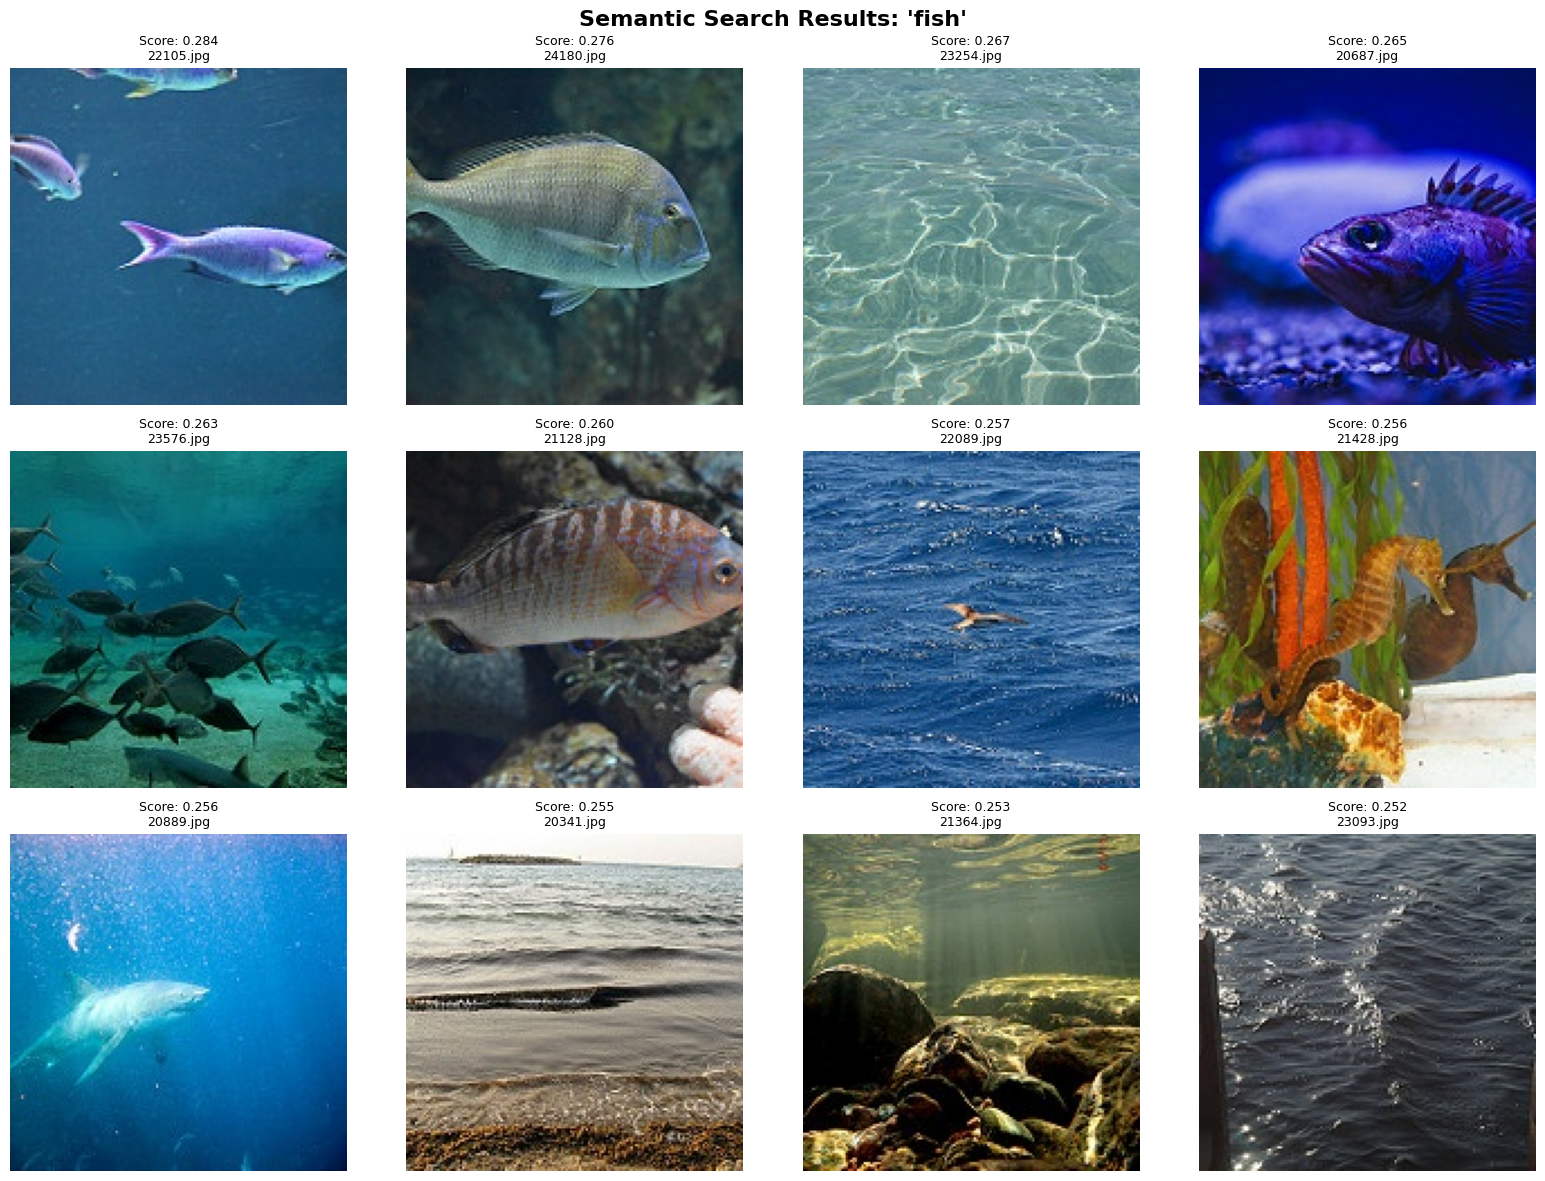


Found 12 results for 'fish'
Top 5 results:
  1. 22105.jpg (similarity: 0.2836)
  2. 24180.jpg (similarity: 0.2756)
  3. 23254.jpg (similarity: 0.2672)
  4. 20687.jpg (similarity: 0.2650)
  5. 23576.jpg (similarity: 0.2632)


In [17]:
# Example: Semantic search for "fish"
query = "fish"
results = semantic_search_images(
    query=query,
    model=model,
    image_embeddings=embeddings,
    images=images,
    image_paths=image_paths,
    top_k=12,
    device=DEVICE
)

display_search_results(query, results, max_display=12)


## Semantic Search

You can now search for images using natural language queries! 

**Usage:**
- Change the `query` variable below to search for anything (e.g., "fish", "red car", "sunset", "dog", "beach")
- The search uses CLIP embeddings to find semantically similar images
- Results are ranked by similarity score (higher = more similar)


In [18]:
# Convenience function for quick searches
def search(query: str, top_k: int = 12):
    """
    Quick semantic search function.
    
    Args:
        query: Text query to search for
        top_k: Number of results to return (default: 12)
    """
    results = semantic_search_images(
        query=query,
        model=model,
        image_embeddings=embeddings,
        images=images,
        image_paths=image_paths,
        top_k=top_k,
        device=DEVICE
    )
    display_search_results(query, results, max_display=top_k)
    return results

# Try it out! Uncomment and modify the query:
# search("fish")
# search("red car")
# search("sunset")
# search("dog")


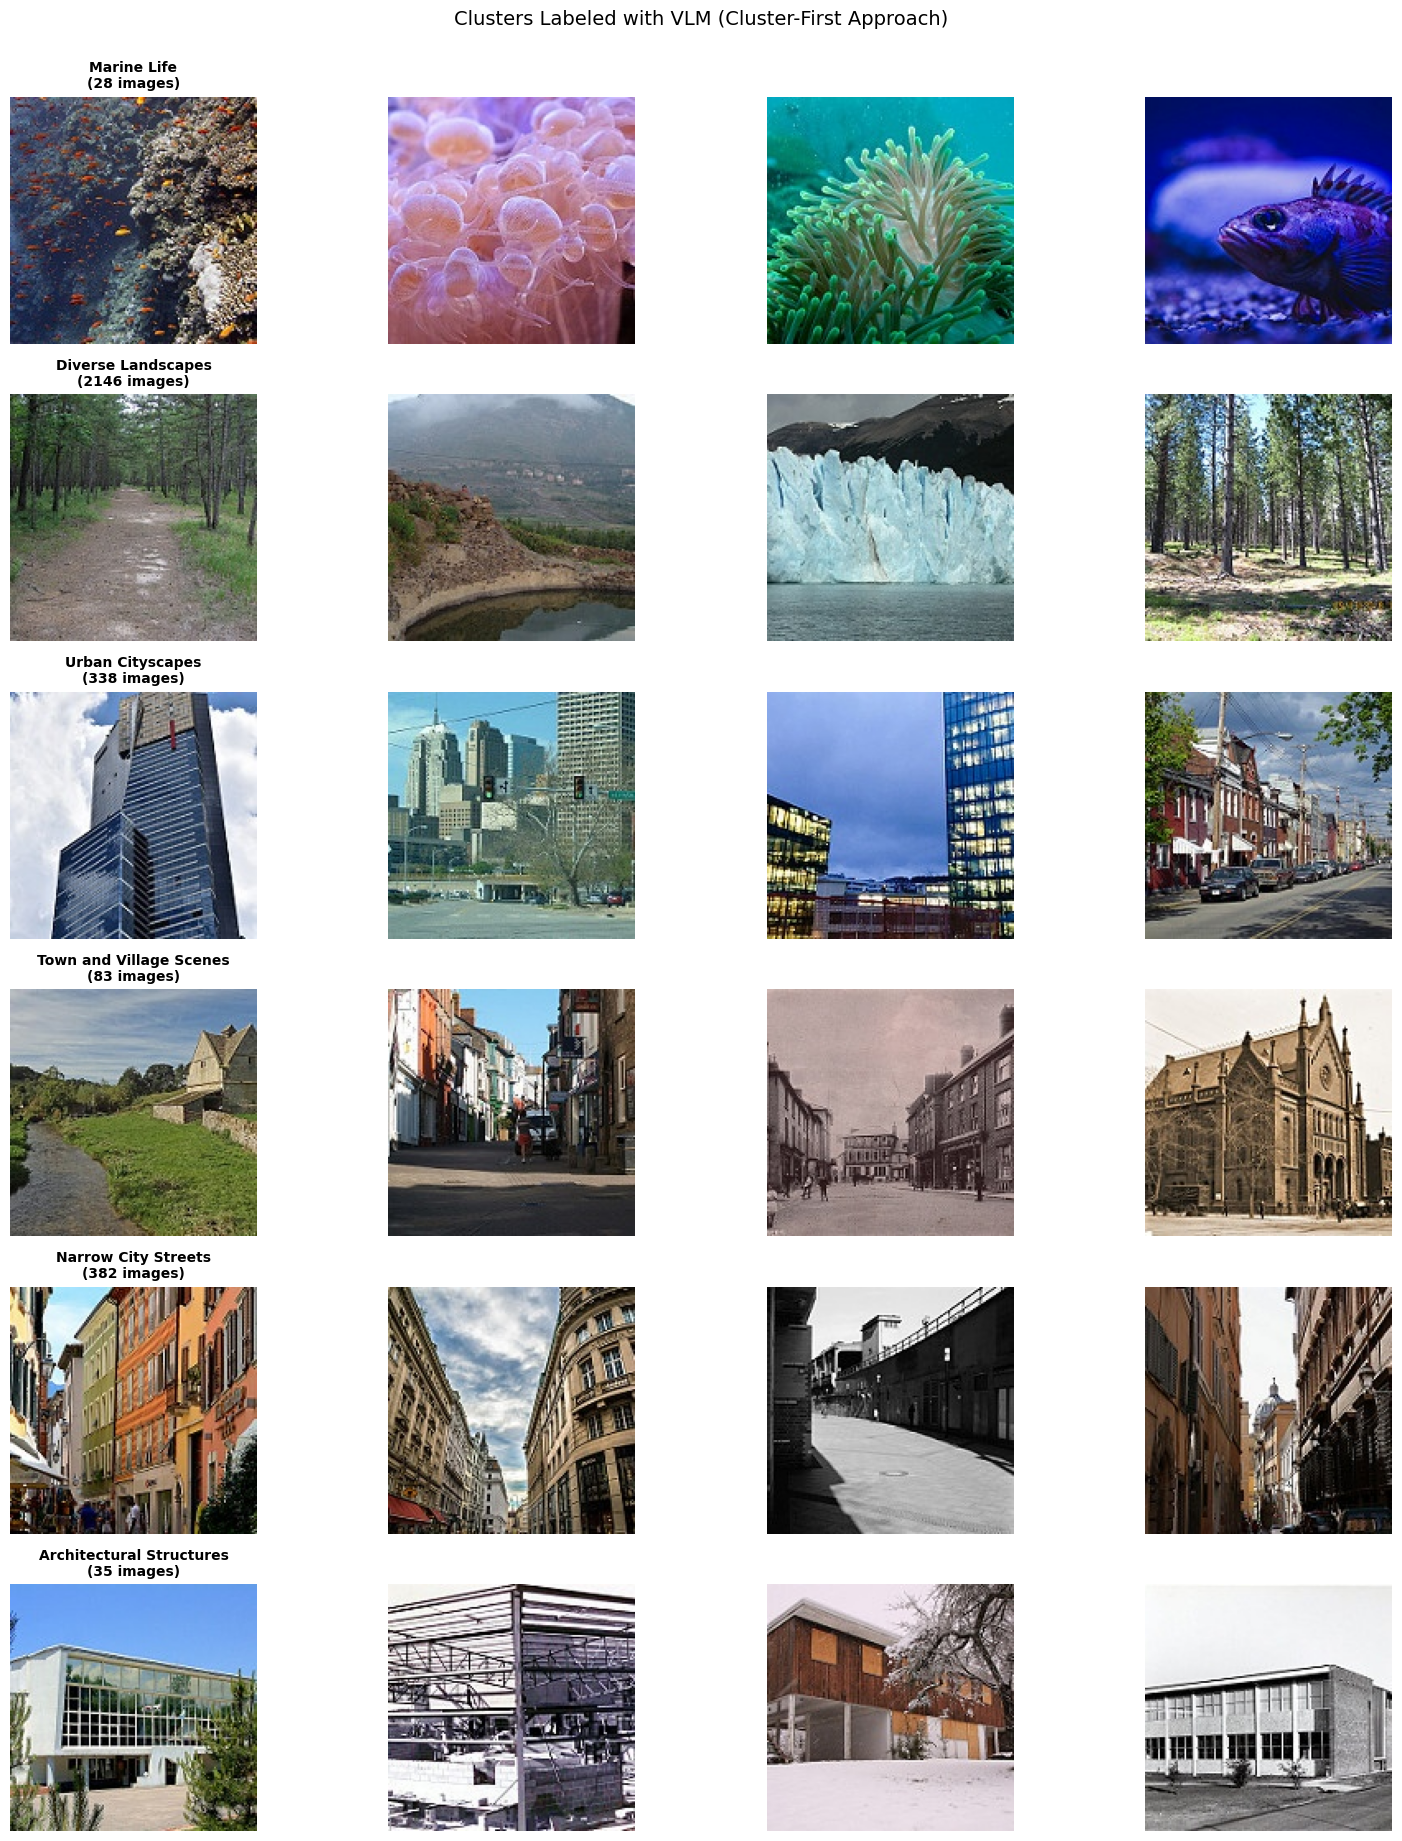

In [19]:
# Visualize labeled clusters
if len(clusters) > 0:
    rows = len(clusters)
    cols = min(4, max(len(items) for items in clusters.values()))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for row_idx, (cluster_id, cluster_images_list) in enumerate(sorted(clusters.items())):
        label_info = cluster_labels.get(cluster_id, {})
        cluster_name = label_info.get("cluster_name", f"Cluster {cluster_id}")
        
        for col_idx in range(cols):
            ax = axes[row_idx][col_idx]
            if col_idx < len(cluster_images_list):
                ax.imshow(cluster_images_list[col_idx])
                if col_idx == 0:
                    ax.set_title(f"{cluster_name}\n({len(cluster_images_list)} images)", 
                               fontsize=10, fontweight="bold")
            ax.axis("off")
    
    plt.tight_layout()
    plt.suptitle("Clusters Labeled with VLM (Cluster-First Approach)", fontsize=14, y=1.02)
    plt.show()
else:
    print("No clusters to visualize")
